In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
sns.set(style="darkgrid")
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df['response'] = (df.y == 'yes').astype('int')

In [5]:
numerical_vars =  ['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'nr.employed','age','euribor3m']
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Treating Missing values

In [8]:
# Replacing missing values with mean in numerical columns
mean = df[numerical_vars]
df[numerical_vars].fillna(mean, inplace=True)

In [9]:
# Replacing missing values with empty string in categorical columns
df[categorical_vars].fillna('', inplace=True)

Scaling and Encoding

In [10]:

#Encoding categorical variables
df_cat=pd.get_dummies(df[categorical_vars], drop_first = False, dtype=int)
df_cat.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
# Scaling numerical variables
scaler = MinMaxScaler()
scaler.fit(df[numerical_vars])
scalerfile = 'scaler.sav'
# saving scaler to be used at Inference
pickle.dump(scaler, open(scalerfile, 'wb'))
scaled = scaler.transform(df[numerical_vars])
df_num = pd.DataFrame(scaled, columns=numerical_vars)
df_num.head()

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,age,euribor3m
0,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.859735,0.481481,0.957379
1,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.859735,0.493827,0.957379
2,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.859735,0.246914,0.957379
3,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.859735,0.283951,0.957379
4,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.859735,0.481481,0.957379


### Creating input dataset

In [12]:
X = pd.concat([df_cat, df_num], axis = 1)
y = df['response']

In [82]:
# Saving column names for sanity check during inference
cols_training = X.columns
pickle.dump(cols_training, open('cols_training.sav', 'wb'))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=2024)

### Evaluation metrics

In [14]:

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    f1 = 2 * (precision * recall) / (precision + recall)
   
    print(f"AUC: {auc}")
    print(f"accuracy: {accuracy}")
    print(f"recall: {recall}")
    print(f"precision: {precision}")
    print(f"f1: {f1}")
    print(' ')
    return auc, accuracy, recall, precision, f1

In [15]:
thresh = 0.5

### Training models and calculating accuracy

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)

y_train_preds = knn.predict_proba(X_train)[:,1]
y_valid_preds = knn.predict_proba(X_test)[:,1]

print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision,  knn_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision,  knn_valid_f1 = print_report(y_test,y_valid_preds, thresh)

Training:
AUC: 0.8134047569785894
accuracy: 0.8966043494849294
recall: 0.13516009852216748
precision: 0.7184942716857611
f1: 0.22752008292303708
 
Validation:
AUC: 0.7650507295941633
accuracy: 0.8973051711580481
recall: 0.13936781609195403
precision: 0.7320754716981132
f1: 0.23415811707905856
 


In [17]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_test)[:,1]

print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_f1 = print_report(y_test,y_valid_preds, thresh)

Training:
AUC: 0.7970174207433393
accuracy: 0.9005931115812841
recall: 0.23214285714285715
precision: 0.6696269982238011
f1: 0.3447645176040238
 
Validation:
AUC: 0.7877423463370914
accuracy: 0.9002184996358339
recall: 0.21910919540229884
precision: 0.6762749445676275
f1: 0.33098209441128595
 


In [18]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_train_preds = nb.predict_proba(X_train)[:,1]
y_valid_preds = nb.predict_proba(X_test)[:,1]


print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, \
    nb_train_precision, nb_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, \
    nb_valid_precision, nb_valid_f1 = print_report(y_test,y_valid_preds, thresh)

Training:
AUC: 0.7721162923962936
accuracy: 0.7918559883458777
recall: 0.6339285714285714
precision: 0.29966525978751274
f1: 0.4069572092103963
 
Validation:
AUC: 0.7642558807805401
accuracy: 0.7993040381969734
recall: 0.6221264367816092
precision: 0.3070921985815603
f1: 0.4112060778727445
 


In [22]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train, y_train)
y_train_preds = tree.predict_proba(X_train)[:,1]
y_valid_preds = tree.predict_proba(X_test)[:,1]


print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, \
    tree_train_precision, tree_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, \
    tree_valid_precision, tree_valid_f1 = print_report(y_test,y_valid_preds, thresh)

Training:
AUC: 0.836209435857286
accuracy: 0.9188373625611321
recall: 0.3811576354679803
precision: 0.7895408163265306
f1: 0.5141196013289037
 
Validation:
AUC: 0.7340053055437625
accuracy: 0.8954438779639071
recall: 0.2650862068965517
precision: 0.5783699059561128
f1: 0.36354679802955664
 


In [19]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train, y_train)
y_train_preds = rf.predict_proba(X_train)[:,1]
y_valid_preds = rf.predict_proba(X_test)[:,1]


print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, \
    rf_train_precision, rf_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, \
    rf_valid_precision, rf_valid_f1 = print_report(y_test,y_valid_preds, thresh)

Training:
AUC: 0.8088128681511679
accuracy: 0.9010440151226111
recall: 0.1816502463054187
precision: 0.7515923566878981
f1: 0.2925861641457972
 
Validation:
AUC: 0.7872939499242626
accuracy: 0.8999757222626851
recall: 0.18031609195402298
precision: 0.7254335260115607
f1: 0.28883774453394706
 


In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train, y_train)
y_train_preds = gbc.predict_proba(X_train)[:,1]
y_valid_preds = gbc.predict_proba(X_test)[:,1]


print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, \
    gbc_train_precision,  gbc_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, \
    gbc_valid_precision, gbc_valid_f1 = print_report(y_test,y_valid_preds, thresh)

Training:
AUC: 0.846744106019064
accuracy: 0.9195657452048143
recall: 0.3922413793103448
precision: 0.7869054972205065
f1: 0.5235257859050749
 
Validation:
AUC: 0.7729913884826852
accuracy: 0.8955248037549567
recall: 0.28089080459770116
precision: 0.5741556534508077
f1: 0.37723106608779544
 


## Comparing results of all models

In [26]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*6,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_train_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_train_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_train_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_train_precision,gbc_valid_precision,],
                          'f1':[knn_train_f1, knn_valid_f1,lr_train_f1,lr_valid_f1,nb_train_f1,nb_valid_f1,tree_train_f1,tree_valid_f1,rf_train_f1,rf_valid_f1,gbc_train_f1,gbc_valid_f1,],
                          })

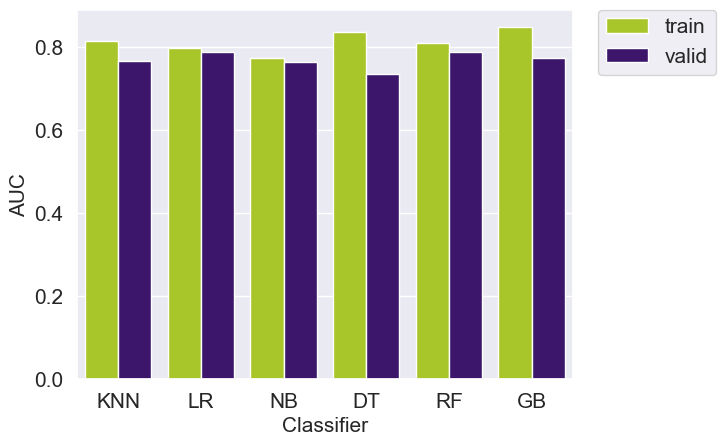

In [27]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results, palette=['#b8df10',"#390879"])
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

Best model according to AUC score on Training and Validation dataset is GradientBoostingClassifier. AUC is used as a final metric because of imbalance dataset.

### Feature Importance

In [47]:
cols_input = X_train.columns
feature_importances = pd.DataFrame(gbc.feature_importances_,
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

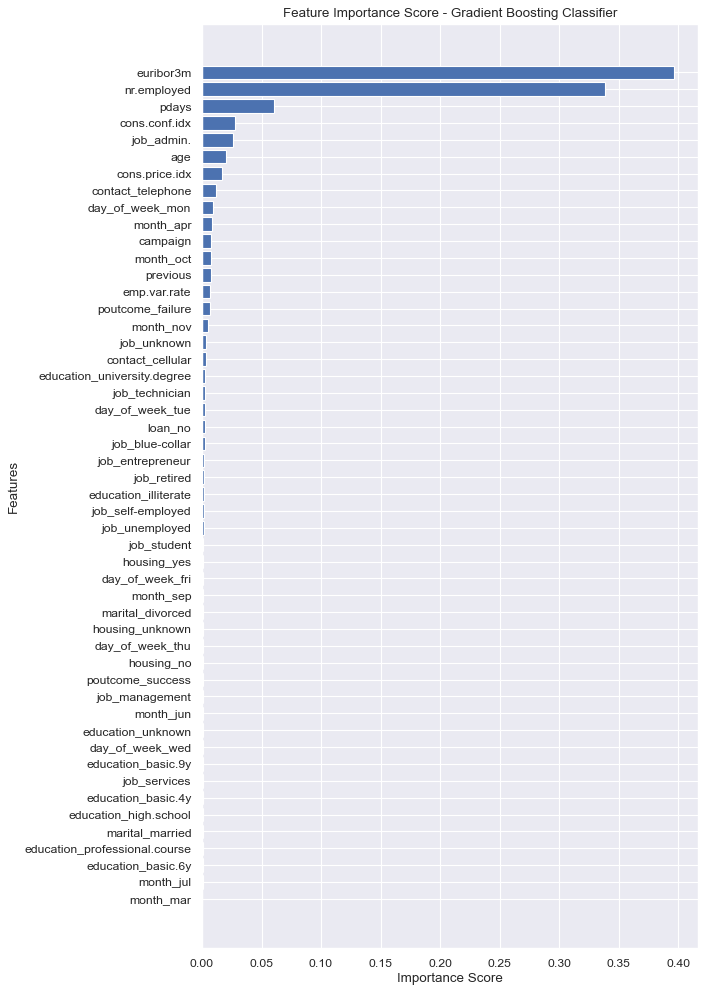

In [48]:
num = np.min([50, len(cols_input)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Gradient Boosting Classifier')
plt.yticks(ylocs, feature_labels)
plt.show()

### Hyperparameter Tuning

In [49]:
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)
# number of trees
n_estimators = range(50,200,50)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train, y_train)
t2 = time.time()
print(t2-t1)

107.38390016555786


In [50]:
gbc_random.best_params_

{'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}

In [51]:
y_train_preds = gbc.predict_proba(X_train)[:,1]
y_valid_preds = gbc.predict_proba(X_test)[:,1]

thresh = 0.5

print('Baseline gbc')
gbc_train_base_auc = roc_auc_score(y_train, y_train_preds)
gbc_valid_base_auc = roc_auc_score(y_test, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_base_auc))
print('Validation AUC:%.3f'%(gbc_valid_base_auc))
print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_test)[:,1]
gbc_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_opt_auc = roc_auc_score(y_test, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_opt_auc))
print('Validation AUC:%.3f'%(gbc_valid_opt_auc))

Baseline gbc
Training AUC:0.834
Validation AUC:0.781
Optimized gbc
Training AUC:0.832
Validation AUC:0.795


Accuracy on validation dataset slightly improved after hyperparameter tuning.

In [52]:
# Model was saved for inference
pickle.dump(gbc_random.best_estimator_, open('best_model_gbc2.pkl', 'wb'),protocol = 4)